In [1]:
%load_ext autoreload
%autoreload 2
import os
os.sys.path.insert(0, '/home/ai/Documents/braindecode-master/braindecode')

# Cropped Decoding

Now we will use cropped decoding. Cropped decoding means the ConvNet is trained on time windows/time crops within the trials. Most of the code is identical to the [Trialwise Decoding Tutorial](TrialWise_Decoding.html), differences are explained in the text.

## Load data

In [2]:
import scipy.io as sio
ma_contents = sio.loadmat('dataset_BCIcomp1.mat')
ma_contents

import mne
from mne.io import concatenate_raws

# 5,6,7,10,13,14 are codes for executed and imagined hands/feet
subject_id = [1] #,11,12,13,14,15,16,17,18,19,20]


## Convert data to Braindecode format

In [3]:
import numpy as np
from braindecode.datautil.signal_target import SignalAndTarget
# Convert data from volt to millivolt
# Pytorch expects float32 for input and int64 for labels.


X_train = ma_contents['x_train']
X_train = np.transpose(X_train)
X_train = X_train.astype(np.float32)
#X_train = X_train[1012:,:,:]
print(X_train.shape)
y_train = ma_contents['y_train']
y_train = y_train.reshape(140,)
y_train = (y_train - 1).astype(np.int64)  #1,2 -> 0,1
print(y_train)
X_test = ma_contents['x_test']



train_set = SignalAndTarget(X_train[:60], y=y_train[:60])
test_set = SignalAndTarget(X_train[60:], y=y_train[60:])


(140, 3, 1152)
[0 1 1 1 1 0 0 1 1 0 0 1 0 1 1 1 1 0 0 0 0 1 0 1 0 1 1 1 1 0 0 1 0 1 0 0 0
 0 0 1 1 1 1 0 0 1 0 1 1 0 1 1 1 0 1 1 0 1 1 0 1 0 1 0 1 1 1 1 1 0 1 0 1 0
 0 0 0 1 0 1 0 1 1 0 0 0 1 0 0 0 0 0 0 1 1 0 1 0 0 0 1 1 1 0 1 1 1 0 0 1 1
 1 0 0 1 0 0 0 1 0 1 0 0 0 1 1 0 1 0 1 0 0 1 0 0 1 0 1 1 0]


## Create the model

For cropped decoding, we now transform the model into a model that outputs a dense time series of predictions.
For this, we manually set the length of the final convolution layer to some length that makes the receptive field of the ConvNet smaller than the number of samples in a trial. Also, we use `to_dense_prediction_model`, which removes the strides in the ConvNet and instead uses dilated convolutions to get a dense output (see [Multi-Scale Context Aggregation by Dilated Convolutions](https://arxiv.org/abs/1511.07122) and our paper [Deep learning with convolutional neural networks for EEG decoding and visualization](https://arxiv.org/abs/1703.05051) Section 2.5.4 for some background on this).

In [4]:
from braindecode1.models.shallow_fbcsp_conv3 import ShallowFBCSPNet
from braindecode1.models.deep5 import Deep4Net

#from torch import nn
from braindecode.torch_ext.util import set_random_seeds
from braindecode.models.util import to_dense_prediction_model

# Set if you want to use GPU
# You can also use torch.cuda.is_available() to determine if cuda is available on your machine.
cuda = False
set_random_seeds(seed=20170629, cuda=cuda)

# This will determine how many crops are processed in parallel
input_time_length = 450

n_classes = 2

for ids in subject_id:
    
    print(train_set.X.shape[1])
    in_chans = train_set.X.shape[1]
    # final_conv_length determines the size of the receptive field of the ConvNet
    model =  Deep4Net(in_chans=in_chans, n_classes=n_classes, input_time_length=input_time_length, stride_before_pool=True,
                        pool_time_stride=2,final_conv_length=1).create_network()

    to_dense_prediction_model(model)
    print(model)
    if cuda:
        model.cuda()


    from torch import optim

    optimizer = optim.Adam(model.parameters())

3
Sequential(
  (dimshuffle): Expression(expression=_transpose_time_to_spat)
  (conv_time): Conv2d(1, 25, kernel_size=(10, 1), stride=(1, 1))
  (conv_spat): Conv2d(25, 25, kernel_size=(1, 3), stride=(1, 1), bias=False)
  (bnorm): BatchNorm2d(25, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
  (conv_nonlin): Expression(expression=elu)
  (pool): MaxPool2d(kernel_size=(3, 1), stride=(1, 1), padding=0, dilation=(2, 1), ceil_mode=False)
  (pool_nonlin): Expression(expression=identity)
  (drop_2): Dropout(p=0.5)
  (conv_2): Conv2d(25, 50, kernel_size=(10, 1), stride=(1, 1), dilation=(2, 1), bias=False)
  (bnorm_2): BatchNorm2d(50, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
  (nonlin_2): Expression(expression=elu)
  (pool_2): MaxPool2d(kernel_size=(3, 1), stride=(1, 1), padding=0, dilation=(4, 1), ceil_mode=False)
  (pool_nonlin_2): Expression(expression=identity)
  (drop_3): Dropout(p=0.5)
  (conv_3): Conv2d(50, 100, kernel_size=(10, 1), stride=(1, 1), 

/home/dansy/Documents/braindecode-master/braindecode1/models/deep5.py:159: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  init.xavier_uniform(model.conv_time.weight, gain=1)
/home/dansy/Documents/braindecode-master/braindecode1/models/deep5.py:162: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  init.constant(model.conv_time.bias, 0)
/home/dansy/Documents/braindecode-master/braindecode1/models/deep5.py:164: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  init.xavier_uniform(model.conv_spat.weight, gain=1)
/home/dansy/Documents/braindecode-master/braindecode1/models/deep5.py:168: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  init.constant(model.bnorm.weight, 1)
/home/dansy/Documents/braindecode-master/braindecode1/models/deep5.py:169: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  init.constant(mo

## Create cropped iterator

For extracting crops from the trials, Braindecode provides the  `CropsFromTrialsIterator?` class. This class needs to know the input time length of the inputs you put into the network and the number of predictions that the ConvNet will output per input. You can determine the number of predictions by passing dummy data through the ConvNet: 

In [5]:
from braindecode.torch_ext.util import np_to_var
# determine output size
test_input = np_to_var(np.ones((2, in_chans, input_time_length, 1), dtype=np.float32))
if cuda:
    test_input = test_input.cuda()
print(test_input.shape)
out = model(test_input)

n_preds_per_input = out.cpu().data.numpy().shape[2]
print("{:d} predictions per input/trial".format(n_preds_per_input))

torch.Size([2, 3, 450, 1])
47 predictions per input/trial


/home/dansy/anaconda3/lib/python3.6/site-packages/torch/nn/modules/container.py:91: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [6]:
from braindecode.datautil.iterators import CropsFromTrialsIterator
iterator = CropsFromTrialsIterator(batch_size=64,input_time_length=input_time_length,
                                  n_preds_per_input=n_preds_per_input)

print(iterator.get_batches(train_set, shuffle=False))

<generator object CropsFromTrialsIterator._yield_block_batches at 0x7fa5f7bc7a40>


The iterator has the method `get_batches`, which can be used to get randomly shuffled training batches with `shuffle=True` or ordered batches (i.e. first from trial 1, then from trial 2, etc.) with `shuffle=False`. Additionally, Braindecode provides the `compute_preds_per_trial_for_set` method, which accepts predictions from the ordered batches and returns predictions per trial. It removes any overlapping predictions, which occur if the number of predictions per input is not a divisor of the number of samples in a trial.


<div class="alert alert-info">

These methods can also work with trials of different lengths! For different-length trials, set `X` to be a list of 2d-arrays instead of a 3d-array.

</div>

## Training loop

The code below uses both the cropped iterator and the `compute_preds_per_trial_for_set` function to train and evaluate the network.

## K Folds cross validation

In [7]:
from sklearn.model_selection import KFold # import KFold for cross validation
from sklearn.datasets import make_classification
from skorch import NeuralNetClassifier

In [8]:
#kf = KFold(n_splits=6) # Define the split - into 3 folds 
kf = KFold(n_splits=5, random_state=7) #evaluate the k fold cross validation


In [9]:
from matplotlib import pyplot as plt


In [10]:
from braindecode.torch_ext.util import np_to_var, var_to_np
import torch.nn.functional as F
from numpy.random import RandomState
import torch as th
from braindecode.experiments.monitors import compute_preds_per_trial_for_set
rng = RandomState((2017,6,30))
accuracy_nb = {"Train": 0, "Test": 0}
accuracy_sum = {"Train": 0, "Test": 0}
accuracyF_nb = {"Train": 0, "Test": 0}
accuracyF_sum = {"Train": 0, "Test": 0}
loss_nb = {"Train": 0, "Test": 0}
loss_sum = {"Train": 0, "Test": 0}
lossF_nb = {"Train": 0, "Test": 0}
lossF_sum = {"Train": 0, "Test": 0}

loss_graph = {"Train": [], "Test": []}
accuracy_graph = {"Train": [], "Test": []}
accuracy_Subject_box = {}
accuracy_box={"Train": [], "Test": []}

for ids in subject_id:
    i_trial_stops = [trial.shape[1] for trial in train_set.X]
    print("Sujet {:d}".format(ids))
    for i_epoch in range(20):
        all_acc = []
        print("Epoch {:d}".format(i_epoch))
        fold=0
        for train_index, test_index in kf.split(train_set.X):
            fold= fold+1
            training_set = SignalAndTarget(train_set.X[train_index], y=y_train[train_index])
            val_set = SignalAndTarget(train_set.X[test_index], y=y_train[test_index])

            # Set model to training mode
            model.train()
            for batch_X, batch_y in iterator.get_batches(training_set, shuffle=False):
                net_in = np_to_var(batch_X)
                if cuda:
                    net_in = net_in.cuda()
                net_target = np_to_var(batch_y)
                if cuda:
                    net_target = net_target.cuda()
                # Remove gradients of last backward pass from all parameters 
                optimizer.zero_grad()
                outputs = model(net_in)
                # Mean predictions across trial
                # Note that this will give identical gradients to computing
                # a per-prediction loss (at least for the combination of log softmax activation 
                # and negative log likelihood loss which we are using here)
                outputs = th.mean(outputs, dim=2, keepdim=False)
                loss = F.nll_loss(outputs, net_target)
                loss.backward()
                optimizer.step()

            # Print some statistics each epoch
            model.eval()
            print("Fold {:d}".format(fold))
            for setname, dataset in (('Train', training_set),('Test', val_set)):

                # Collect all predictions and losses
                all_preds = []
                all_losses = []
                batch_sizes = []
                for batch_X, batch_y in iterator.get_batches(dataset, shuffle=False):
                    net_in = np_to_var(batch_X)
                    if cuda:
                        net_in = net_in.cuda()
                    net_target = np_to_var(batch_y)
                    if cuda:
                        net_target = net_target.cuda()
                    outputs = model(net_in)
                    all_preds.append(var_to_np(outputs))
                    outputs = th.mean(outputs, dim=2, keepdim=False)
                    loss = F.nll_loss(outputs, net_target)
                    loss = float(var_to_np(loss))
                    all_losses.append(loss)
                    batch_sizes.append(len(batch_X))
                # Compute mean per-input loss 
                loss = np.mean(np.array(all_losses) * np.array(batch_sizes) /
                               np.mean(batch_sizes))
                print("{:6s} Loss: {:.5f}".format(setname, loss))
                
                # Assign the predictions to the trials
                preds_per_trial = compute_preds_per_trial_for_set(all_preds,
                                                                  input_time_length,
                                                                  dataset)
                # preds per trial are now trials x classes x timesteps/predictions
                # Now mean across timesteps for each trial to get per-trial predictions
                meaned_preds_per_trial = np.array([np.mean(p, axis=1) for p in preds_per_trial])
                predicted_labels = np.argmax(meaned_preds_per_trial, axis=1)
                accuracy = np.mean(predicted_labels == dataset.y)

                print("{:6s} Accuracy: {:.1f}%".format(
                    setname, accuracy * 100))
                
    #for i_epoch in range(2):
    
        # Set model to training mode
        model.train()
        for batch_X, batch_y in iterator.get_batches(train_set, shuffle=False):
            net_in = np_to_var(batch_X)
            if cuda:
                net_in = net_in.cuda()
            net_target = np_to_var(batch_y)
            if cuda:
                net_target = net_target.cuda()
            # Remove gradients of last backward pass from all parameters 
            optimizer.zero_grad()
            outputs = model(net_in)
            # Mean predictions across trial
            # Note that this will give identical gradients to computing
            # a per-prediction loss (at least for the combination of log softmax activation 
            # and negative log likelihood loss which we are using here)
            outputs = th.mean(outputs, dim=2, keepdim=False)
            loss = F.nll_loss(outputs, net_target)
            loss.backward()
            optimizer.step()

        # Print some statistics each epoch
        model.eval()
        print("Epoch Test {:d}".format(i_epoch))
        for setname, dataset in (('Train', train_set),('Test', test_set)):
            # Collect all predictions and losses
            all_preds = []
            all_losses = []
            batch_sizes = []
            for batch_X, batch_y in iterator.get_batches(dataset, shuffle=False):
                net_in = np_to_var(batch_X)
                if cuda:
                    net_in = net_in.cuda()
                net_target = np_to_var(batch_y)
                if cuda:
                    net_target = net_target.cuda()
                outputs = model(net_in)
                all_preds.append(var_to_np(outputs))
                outputs = th.mean(outputs, dim=2, keepdim=False)
                loss = F.nll_loss(outputs, net_target)
                loss = float(var_to_np(loss))
                all_losses.append(loss)
                batch_sizes.append(len(batch_X))
            # Compute mean per-input loss 
            loss = np.mean(np.array(all_losses) * np.array(batch_sizes) /
                           np.mean(batch_sizes))
            print("{:6s} Loss: {:.5f}".format(setname, loss))
            loss_nb[setname] += 1
            loss_sum[setname] += loss
            # Assign the predictions to the trials
            preds_per_trial = compute_preds_per_trial_for_set(all_preds,
                                                              input_time_length,
                                                              dataset)
            # preds per trial are now trials x classes x timesteps/predictions
            # Now mean across timesteps for each trial to get per-trial predictions
            meaned_preds_per_trial = np.array([np.mean(p, axis=1) for p in preds_per_trial])
            predicted_labels = np.argmax(meaned_preds_per_trial, axis=1)
            accuracy = np.mean(predicted_labels == dataset.y)
            print("{:6s} Accuracy: {:.1f}%".format(
                setname, accuracy * 100))
            accuracy_box[setname].append(accuracy * 100)
            accuracy_nb[setname] += 1
            accuracy_sum[setname] += accuracy    
    accuracy_Subject_box[ids]= accuracy_box["Test"]
    accuracy_box["Test"]=[]  
    for setname in ("Train", "Test"):
        print("{} Average accuracy: {:.1f}%".format(setname, accuracy_sum[setname]*100/accuracy_nb[setname]))

Sujet 1
Epoch 0


/home/dansy/anaconda3/lib/python3.6/site-packages/torch/nn/modules/container.py:91: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Fold 1
Train  Loss: 4.76768
Train  Accuracy: 45.8%
Test   Loss: 5.63701
Test   Accuracy: 41.7%
Fold 2
Train  Loss: 1.94402
Train  Accuracy: 43.8%
Test   Loss: 1.74891
Test   Accuracy: 50.0%
Fold 3
Train  Loss: 1.74063
Train  Accuracy: 45.8%
Test   Loss: 1.43426
Test   Accuracy: 50.0%
Fold 4
Train  Loss: 0.89781
Train  Accuracy: 68.8%
Test   Loss: 1.16355
Test   Accuracy: 58.3%
Fold 5
Train  Loss: 0.93790
Train  Accuracy: 52.1%
Test   Loss: 0.84543
Test   Accuracy: 58.3%
Epoch Test 0
Train  Loss: 1.57789
Train  Accuracy: 58.3%
Test   Loss: 1.59245
Test   Accuracy: 58.8%
Epoch 1
Fold 1
Train  Loss: 1.11260
Train  Accuracy: 52.1%
Test   Loss: 1.45553
Test   Accuracy: 50.0%
Fold 2
Train  Loss: 1.52664
Train  Accuracy: 45.8%
Test   Loss: 1.13849
Test   Accuracy: 50.0%
Fold 3
Train  Loss: 1.13803
Train  Accuracy: 45.8%
Test   Loss: 1.18940
Test   Accuracy: 50.0%
Fold 4
Train  Loss: 1.34792
Train  Accuracy: 45.8%
Test   Loss: 1.51716
Test   Accuracy: 50.0%
Fold 5
Train  Loss: 0.89407
Train  A

Fold 1
Train  Loss: 0.26691
Train  Accuracy: 89.6%
Test   Loss: 0.89488
Test   Accuracy: 75.0%
Fold 2
Train  Loss: 0.37749
Train  Accuracy: 89.6%
Test   Loss: 0.14147
Test   Accuracy: 100.0%
Fold 3
Train  Loss: 0.30071
Train  Accuracy: 91.7%
Test   Loss: 0.20607
Test   Accuracy: 100.0%
Fold 4
Train  Loss: 0.26574
Train  Accuracy: 93.8%
Test   Loss: 0.29996
Test   Accuracy: 91.7%
Fold 5
Train  Loss: 0.29245
Train  Accuracy: 93.8%
Test   Loss: 0.21894
Test   Accuracy: 91.7%
Epoch Test 14
Train  Loss: 0.32607
Train  Accuracy: 93.3%
Test   Loss: 1.64152
Test   Accuracy: 66.2%
Epoch 15
Fold 1
Train  Loss: 0.22625
Train  Accuracy: 95.8%
Test   Loss: 0.89743
Test   Accuracy: 75.0%
Fold 2
Train  Loss: 0.36703
Train  Accuracy: 95.8%
Test   Loss: 0.14169
Test   Accuracy: 100.0%
Fold 3
Train  Loss: 0.26681
Train  Accuracy: 93.8%
Test   Loss: 0.24613
Test   Accuracy: 91.7%
Fold 4
Train  Loss: 0.24030
Train  Accuracy: 95.8%
Test   Loss: 0.24969
Test   Accuracy: 100.0%
Fold 5
Train  Loss: 0.25164
Tr

In [11]:
accuracy_box

{'Train': [58.333333333333336,
  45.0,
  51.66666666666667,
  51.66666666666667,
  61.66666666666667,
  65.0,
  66.66666666666666,
  76.66666666666667,
  85.0,
  88.33333333333333,
  83.33333333333334,
  90.0,
  96.66666666666667,
  93.33333333333333,
  93.33333333333333,
  96.66666666666667,
  96.66666666666667,
  93.33333333333333,
  96.66666666666667,
  96.66666666666667],
 'Test': []}

In [12]:
accuracy_Subject_box

{1: [58.75,
  55.00000000000001,
  55.00000000000001,
  53.75,
  55.00000000000001,
  58.75,
  61.25000000000001,
  63.74999999999999,
  65.0,
  62.5,
  65.0,
  65.0,
  65.0,
  65.0,
  66.25,
  65.0,
  63.74999999999999,
  62.5,
  65.0,
  66.25]}

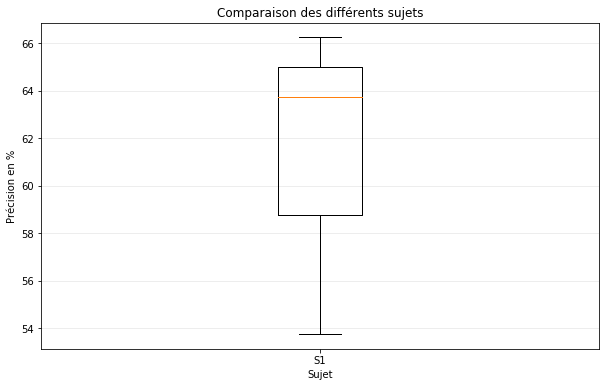

In [13]:
data =[accuracy_Subject_box[1]]

fig, ax1 = plt.subplots(figsize=(10, 6))
fig.canvas.set_window_title('A Boxplot Example')
#fig.subplots_adjust(left=0.075, right=0.95, top=0.9, bottom=0.25)

bp = ax1.boxplot(data, notch=0, sym='+', vert=1, whis=1.5)
plt.setp(bp['boxes'], color='black')
plt.setp(bp['whiskers'], color='black')
plt.setp(bp['fliers'], color='red', marker='+')

# Add a horizontal grid to the plot, but make it very light in color
# so we can use it for reading data values but not be distracting
ax1.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
               alpha=0.5)

# Hide these grid behind plot objects
ax1.set_axisbelow(True)
ax1.set_title('Comparaison des différents sujets')
ax1.set_xlabel('Sujet')
ax1.set_ylabel('Précision en %')

ax1.set_xticklabels(['S1', 'S2', 'S3', 'S4', 'S5', 'S6','S7','S8','S9','S10','S11','S12','S13', 'S14', 'S15', 'S16', 'S17', 'S18', 'S19', 'S20'])


plt.show()

## Leave one out cross validation 

In [14]:
from sklearn.model_selection import LeaveOneOut

loo = LeaveOneOut()
loo.get_n_splits(X)


for train_index, test_index in loo.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    print(X_train, X_test, y_train, y_test)

NameError: name 'X' is not defined

## Dataset References


 This dataset was created and contributed to PhysioNet by the developers of the [BCI2000](http://www.schalklab.org/research/bci2000) instrumentation system, which they used in making these recordings. The system is described in:
 
     Schalk, G., McFarland, D.J., Hinterberger, T., Birbaumer, N., Wolpaw, J.R. (2004) BCI2000: A General-Purpose Brain-Computer Interface (BCI) System. IEEE TBME 51(6):1034-1043.

[PhysioBank](https://physionet.org/physiobank/) is a large and growing archive of well-characterized digital recordings of physiologic signals and related data for use by the biomedical research community and further described in:

    Goldberger AL, Amaral LAN, Glass L, Hausdorff JM, Ivanov PCh, Mark RG, Mietus JE, Moody GB, Peng C-K, Stanley HE. (2000) PhysioBank, PhysioToolkit, and PhysioNet: Components of a New Research Resource for Complex Physiologic Signals. Circulation 101(23):e215-e220.